In [1]:
import os
print(os.getcwd())

C:\Users\MITUL\Documents\csv\NLP


In [2]:
os.chdir('C:\\Users\\MITUL\\Documents\\csv\\vision\\classification')

In [3]:
import torch
from torchvision import transforms, datasets
import seaborn as sns
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [4]:
# Define transformations for image preprocessing
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Define the root directory where your data is located
root_dir = "C:/Users/MITUL/Documents/csv/vision/classification"

# Create datasets for fruits and vegetables
fruits_train_dataset = ImageFolder(root=f"{root_dir}/train/fruits", transform=transform)
fruits_test_dataset = ImageFolder(root=f"{root_dir}/test/fruits", transform=transform)
fruits_validate_dataset = ImageFolder(root=f"{root_dir}/validation/fruits", transform=transform)

vegetables_train_dataset = ImageFolder(root=f"{root_dir}/train/vegetables", transform=transform)
vegetables_test_dataset = ImageFolder(root=f"{root_dir}/test/vegetables", transform=transform)
vegetables_validate_dataset = ImageFolder(root=f"{root_dir}/validation/vegetables", transform=transform)

# Specify batch size for data loaders
batch_size = 32

# Create data loaders for training and testing
fruits_train_loader = DataLoader(fruits_train_dataset, batch_size=batch_size, shuffle=True)
fruits_test_loader = DataLoader(fruits_test_dataset, batch_size=batch_size, shuffle=False)
fruits_validate_loader = DataLoader(fruits_validate_dataset, batch_size=batch_size, shuffle=False)

vegetables_train_loader = DataLoader(vegetables_train_dataset, batch_size=batch_size, shuffle=True)
vegetables_test_loader = DataLoader(vegetables_test_dataset, batch_size=batch_size, shuffle=False)
vegetables_validate_loader = DataLoader(vegetables_validate_dataset, batch_size=batch_size, shuffle=False)

In [5]:
num_classes = 10

In [31]:
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(512 * 16 * 16, 32)  # One dense layer
        self.fc2 = nn.Linear(32, num_classes)
        self.relu = nn.SELU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.relu(self.conv3(x))
        x = self.pool(x)
        x = self.relu(self.conv4(x))
        x = self.pool(x)
        x = x.view(-1, 512 * 16 * 16)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x


model=CustomCNN()

In [32]:
import torch

# Check if CUDA (GPU) is available and set the device accordingly
if torch.cuda.is_available():
    device = torch.device("cuda")



In [33]:
device

device(type='cuda')

In [34]:
import torchvision.transforms.functional as TF

def convert(image_tensor):
    # Remove the alpha channel (4th channel)
    rgb_tensor = image_tensor[:, :3, :, :]
    return rgb_tensor


In [35]:
# Move your model to the GPU
model.to(device)

CustomCNN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=131072, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=10, bias=True)
  (relu): SELU()
)

In [18]:
criterion = nn.CrossEntropyLoss()
# Define optimizer (e.g., Adam)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [12]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Initialize the ReduceLROnPlateau scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=5, verbose=True)


In [ ]:
num_epochs = 32
for epoch in range(num_epochs):
    model.train()
    for inputs, labels in fruits_train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = convert(inputs)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
    # Print loss and accuracy at the end of each epoch
    model.eval()
    with torch.no_grad():
        total_loss = 0.0
        total_correct = 0
        total_samples = 0
        for inputs, labels in fruits_test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = convert(inputs)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)
        accuracy = total_correct / total_samples
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss:.4f}, Accuracy: {accuracy:.4f}")

# Calculate and print classification metrics
true_labels = []
predicted_labels = []
model.eval()
with torch.no_grad():
    for inputs, labels in fruits_test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

class_names = fruits_train_dataset.classes
accuracy = accuracy_score(true_labels, predicted_labels)
classification_rep = classification_report(true_labels, predicted_labels, target_names=class_names)
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print(f"Accuracy: {accuracy:.4f}")
print(classification_rep)
print("Confusion Matrix:")
print(conf_matrix)

# Generate the confusion matrix heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
# Define transformations for training, validation, and test sets
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_validate_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [3]:
# Paths for dataset directories
root_dir = "C:/Users/MITUL/Documents/csv/vision/classification"
train_dir = f"{root_dir}/train"
test_dir = f"{root_dir}/test"
validate_dir = f"{root_dir}/validation"

In [4]:
# Create datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=test_validate_transform)
validate_dataset = datasets.ImageFolder(root=validate_dir, transform=test_validate_transform)

In [5]:
# Data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
validate_loader = DataLoader(validate_dataset, batch_size=batch_size, shuffle=False)

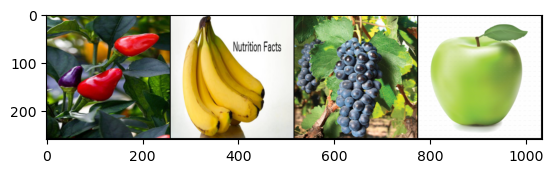

Labels: capsicum banana grapes apple


In [6]:
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

# Paths for dataset directories
root_dir = "C:/Users/MITUL/Documents/csv/vision/classification"
train_dir = f"{root_dir}/train"

# Transforms (adjust as necessary)
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# Create dataset
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)

# Create data loader
batch_size = 4  # Change this to display more or fewer images
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Function to show images
def imshow(img):
    img = img.numpy()
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()

# Get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images))

# Print labels
label_names = [train_dataset.classes[label] for label in labels]
print('Labels:', ' '.join(label_names))


In [7]:
# Determine the number of classes
num_classes = len(train_dataset.classes)
print(num_classes)

10


In [8]:
# Custom CNN definition
class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(256 * 32 * 32, 128)  # Adjust the input features to match your image size
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)
        self.leaky_relu = nn.LeakyReLU()

    def forward(self, x):
        x = self.pool(self.leaky_relu(self.conv1(x)))
        x = self.pool(self.leaky_relu(self.conv2(x)))
        x = self.pool(self.leaky_relu(self.conv3(x)))
        x = x.view(-1, 256 * 32 * 32)  # Adjust the input features to match your image size
        x = self.leaky_relu(self.fc1(x))
        x = self.leaky_relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [9]:
# Now create an instance of your model with the number of classes
model = CustomCNN(num_classes)

In [10]:
# Check if CUDA (GPU) is available and set the device accordingly
if torch.cuda.is_available():
    device = torch.device("cuda")

In [16]:
model.to(device)

CustomCNN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=262144, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (leaky_relu): LeakyReLU(negative_slope=0.01)
)

In [11]:
class EarlyStopping:
    def __init__(self, patience=7, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

In [12]:
early_stopping = EarlyStopping(patience=5, min_delta=0.01)

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

In [ ]:

# Adjust the learning rate
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training and validation loop
num_epochs = 32
for epoch in range(num_epochs):
    # Training phase
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Validation phase
    model.eval()
    total_loss, total_correct, total_samples = 0, 0, len(validate_dataset)
    with torch.no_grad():
        for inputs, labels in validate_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_correct += (predicted == labels).sum().item()

    accuracy = total_correct / total_samples
    scheduler.step(total_loss)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss:.4f}, Accuracy: {accuracy:.4f}")


Epoch 1/32, Loss: 2496577.5625, Accuracy: 0.1031
Epoch 2/32, Loss: 2084423.6875, Accuracy: 0.1237
Epoch 3/32, Loss: 1919639.3750, Accuracy: 0.1443
Epoch 00007: reducing learning rate of group 0 to 1.0000e-03.
Epoch 4/32, Loss: 1785023.0938, Accuracy: 0.1134
Epoch 5/32, Loss: 1730431.0938, Accuracy: 0.1237


In [ ]:
# Evaluation on test set
true_labels, predicted_labels = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

accuracy = accuracy_score(true_labels, predicted_labels)
class_names = train_dataset.classes
classification_rep = classification_report(true_labels, predicted_labels, target_names=class_names)
conf_matrix = confusion_matrix(true_labels, predicted_labels)

In [ ]:

# Display results
print(f"Test Accuracy: {accuracy:.4f}")
print(classification_rep)
print("Confusion Matrix:")
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define transformations for training, validation, and test sets
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_validate_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Paths for dataset directories
root_dir = "C:/Users/MITUL/Documents/csv/vision/classification"
train_dir = f"{root_dir}/train"
test_dir = f"{root_dir}/test"
validate_dir = f"{root_dir}/validation"

# Create datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=test_validate_transform)
validate_dataset = datasets.ImageFolder(root=validate_dir, transform=test_validate_transform)

# Data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
validate_loader = DataLoader(validate_dataset, batch_size=batch_size, shuffle=False)

# Determine the number of classes
num_classes = len(train_dataset.classes)

# Custom CNN definition with batch normalization
class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 32 * 32, 32)  # Adjusted the input features
        self.fc2 = nn.Linear(32, num_classes)
        self.leaky_relu = nn.LeakyReLU()

    def forward(self, x):
        x = self.pool(self.leaky_relu(self.bn1(self.conv1(x))))
        x = self.pool(self.leaky_relu(self.bn2(self.conv2(x))))
        x = self.pool(self.leaky_relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 128 * 32 * 32)
        x = self.leaky_relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Check if CUDA (GPU) is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate model and move it to the device
model = CustomCNN(num_classes).to(device)

# Loss function, optimizer, and scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adjusted learning rate
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

# Training and validation loop
num_epochs = 32
for epoch in range(num_epochs):
    # Training phase
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Validation phase
    model.eval()
    total_loss, total_correct, total_samples = 0, 0, len(validate_dataset)
    with torch.no_grad():
        for inputs, labels in validate_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_correct += (predicted == labels).sum().item()

    accuracy = total_correct / total_samples
    scheduler.step(total_loss)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss:.4f}, Accuracy: {accuracy:.4f}")


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
# Define transformations
train_transform = transforms.Compose([
    transforms.Lambda(lambda image: image.convert('RGB')),  # Convert to RGB
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_validate_transform = transforms.Compose([
    transforms.Lambda(lambda image: image.convert('RGB')),  # Convert to RGB
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [16]:
batch_size=8
num_epochs=32

In [14]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torchvision import datasets, transforms
# from torch.utils.data import DataLoader
# import numpy as np



# Load datasets
root_dir = "C:/Users/MITUL/Documents/csv/vision/classification"
train_dataset = datasets.ImageFolder(root=f"{root_dir}/train", transform=train_transform)
test_dataset = datasets.ImageFolder(root=f"{root_dir}/test", transform=test_validate_transform)
validate_dataset = datasets.ImageFolder(root=f"{root_dir}/validation", transform=test_validate_transform)

# Data loaders
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
validate_loader = DataLoader(validate_dataset, batch_size=batch_size, shuffle=False)




In [33]:
num_classes = len(train_dataset.classes)

class MLP(nn.Module):
    def __init__(self, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(3 * 256 * 256, 512)  # Assuming images are 256x256x3
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(-1, 3 * 256 * 256)  # Flatten the image
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Setup for training
device = torch.device("cuda")
model = MLP(num_classes).to(device)

In [20]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

In [ ]:

# Regularization parameters
l1_lambda = 0.001
l2_lambda = 0.001

# Training loop
for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # L1 Regularization
        l1_norm = sum(p.abs().sum() for p in model.parameters())

        # L2 Regularization
        l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())

        # Combine loss with regularization terms
        loss = loss + l1_lambda * l1_norm + l2_lambda * l2_norm

        loss.backward()
        optimizer.step()

    # Validation phase
    model.eval()
    total_loss, total_correct, total_samples = 0, 0, len(validate_dataset)
    with torch.no_grad():
        for inputs, labels in validate_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_correct += (predicted == labels).sum().item()

    accuracy = total_correct / total_samples

    # Correct call to scheduler's step method
    scheduler.step(total_loss)

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss:.4f}, Accuracy: {accuracy:.4f}")

In [ ]:
import torchvision.models as models

# Load a pretrained ResNet18 model
model = models.resnet18(pretrained=True)

# Freeze all layers in the network
for param in model.parameters():
    param.requires_grad = False

# Replace the final fully connected layer
# ResNet18 typically ends with 512 features going into its final FC layer
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)  # Adjust for your number of classes

# Move the model to the appropriate device
model = model.to(device)

# Loss function and optimizer
# Only parameters of final layers are being optimized
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

# Training loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Validation phase
    # ... (as before)

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss:.4f}, Accuracy: {accuracy:.4f}")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels: tensor([7, 5, 2, 4, 3, 7, 7, 6])


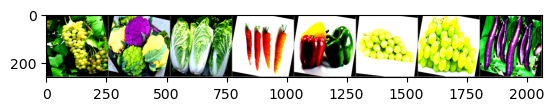

In [28]:
import matplotlib.pyplot as plt
import torchvision

def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Assuming you already have a batch of images and labels from your DataLoader
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images and labels
print("Labels:", labels)
imshow(torchvision.utils.make_grid(images))


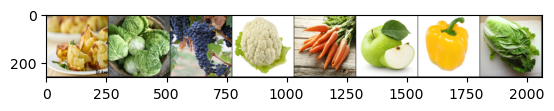

Labels: cauliflower cabbage grapes cauliflower carrot apple capsicum cabbage


In [29]:
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define minimal transformations
minimal_transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize images to a fixed size
    transforms.ToTensor()  # Convert images to PyTorch tensors
])

# Load datasets with minimal transformations
root_dir = "C:/Users/MITUL/Documents/csv/vision/classification"
train_dataset = datasets.ImageFolder(root=f"{root_dir}/train", transform=minimal_transform)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

# Function to show images
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images))

# Print labels
print('Labels:', ' '.join(f'{train_dataset.classes[labels[j]]}' for j in range(len(labels))))


In [30]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define the transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize images to a fixed size
    transforms.ToTensor()           # Convert images to PyTorch tensors
])

# Paths for dataset directories
root_dir = "C:/Users/MITUL/Documents/csv/vision/classification"

# Create datasets with the same transformations
train_dataset = datasets.ImageFolder(root=f"{root_dir}/train", transform=transform)
test_dataset = datasets.ImageFolder(root=f"{root_dir}/test", transform=transform)
validate_dataset = datasets.ImageFolder(root=f"{root_dir}/validation", transform=transform)

# Data loaders
batch_size = 8
num_epochs=16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
validate_loader = DataLoader(validate_dataset, batch_size=batch_size, shuffle=False)


In [38]:
num_classes = len(train_dataset.classes)

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = self.relu(out)
        return out

class ResNetLike(nn.Module):
    def __init__(self, num_classes):
        super(ResNetLike, self).__init__()
        self.in_channels = 128

        self.conv1 = nn.Conv2d(3, 128, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(128)
        self.relu = nn.ReLU(inplace=True)

        self.layer1 = ResidualBlock(128, 256, stride=2)
        self.layer2 = ResidualBlock(256, 512, stride=2)

        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))

        out = self.layer1(out)
        out = self.layer2(out)

        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

# Setup for training
device = torch.device("cuda")
model = ResNetLike(num_classes).to(device)

In [ ]:
l1_lambda = 0.001
l2_lambda = 0.001

# Training loop
for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # L1 Regularization
        l1_norm = sum(p.abs().sum() for p in model.parameters())

        # L2 Regularization
        l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())

        # Combine loss with regularization terms
        loss = loss + l1_lambda * l1_norm + l2_lambda * l2_norm

        loss.backward()
        optimizer.step()

    # Validation phase
    model.eval()
    total_loss, total_correct, total_samples = 0, 0, len(validate_dataset)
    with torch.no_grad():
        for inputs, labels in validate_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_correct += (predicted == labels).sum().item()

    accuracy = total_correct / total_samples

    # Correct call to scheduler's step method
    scheduler.step(total_loss)

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss:.4f}, Accuracy: {accuracy:.4f}")

In [3]:
import os
import numpy as np
from PIL import Image
import pandas as pd

# Define a function to process images in a folder
def process_images(class_name, folder_path, label):
    data = []
    labels = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg"):  # Assuming your images are in JPG format
            image_path = os.path.join(folder_path, filename)
            image = Image.open(image_path)
            # Resize the image to 256x256 pixels
            image = image.resize((256, 256))
            # Ensure the image has 3 channels (RGB)
            if image.mode == "RGB":
                pixel_values = np.array(image)
                data.append(pixel_values.flatten())
                labels.append(label)
    return data, labels

# Define the root directory where your data is located
root_dir = "C:/Users/MITUL/Documents/csv/vision/classification"

# Create empty lists to store data and labels
data = []
labels = []

# Process images in the "train" directory
train_dir = os.path.join(root_dir, "train")
for label, class_name in enumerate(os.listdir(train_dir)):
    class_dir = os.path.join(train_dir, class_name)
    data_temp, labels_temp = process_images(class_name, class_dir, label)
    data.extend(data_temp)
    labels.extend(labels_temp)

# Process images in the "test" directory
test_dir = os.path.join(root_dir, "test")
for label, class_name in enumerate(os.listdir(test_dir)):
    class_dir = os.path.join(test_dir, class_name)
    data_temp, labels_temp = process_images(class_name, class_dir, label)
    data.extend(data_temp)
    labels.extend(labels_temp)

# Process images in the "validation" directory
validation_dir = os.path.join(root_dir, "validation")
for label, class_name in enumerate(os.listdir(validation_dir)):
    class_dir = os.path.join(validation_dir, class_name)
    data_temp, labels_temp = process_images(class_name, class_dir, label)
    data.extend(data_temp)
    labels.extend(labels_temp)

# Convert data and labels to NumPy arrays
data = np.array(data)
labels = np.array(labels)

# Create a DataFrame to store the pixel values and labels
df = pd.DataFrame(data)
df['labels'] = labels

# Save the DataFrame to a CSV file
csv_filename = "image_data.csv"
df.to_csv(csv_filename, index=False)

print(f"Saved image data to {csv_filename}")


Saved image data to image_data.csv


In [ ]:
import cuml
import cudf
import numpy as np
import matplotlib.pyplot as plt

# Load the CSV file containing image data and labels using cuDF
csv_filename = "image_data.csv"
gdf = cudf.read_csv(csv_filename)

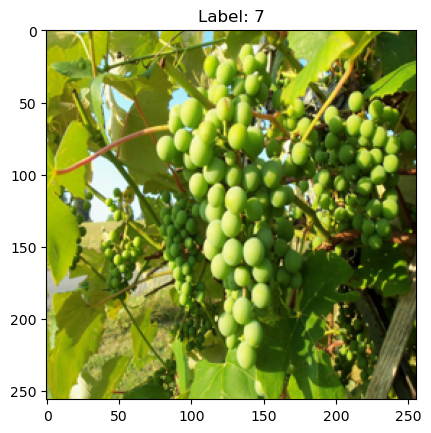

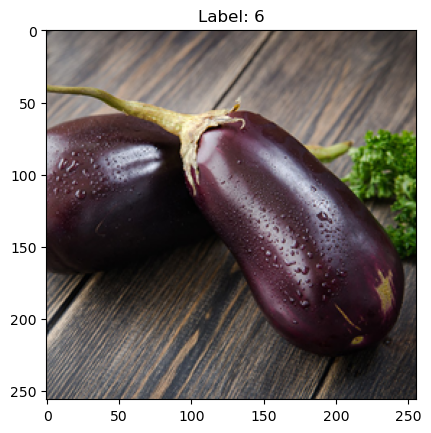

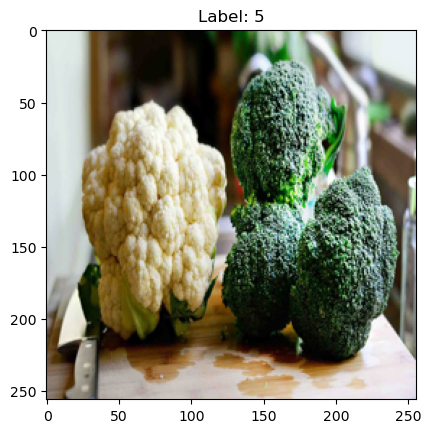

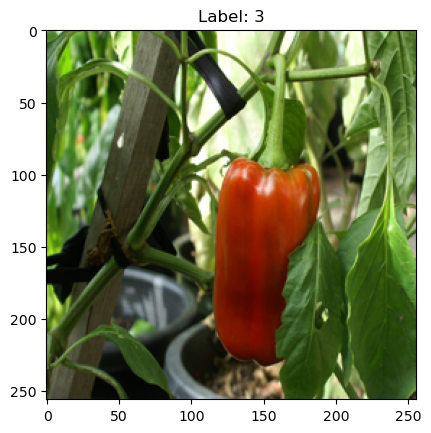

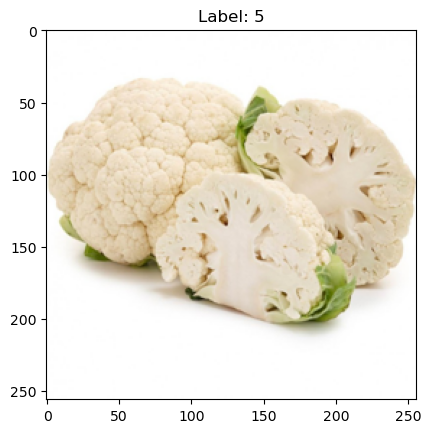

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the CSV file containing image data and labels
csv_filename = "image_data.csv"
df = pd.read_csv(csv_filename)

# Get a sample of images and labels
sample_size = 5  # Change this value to the number of samples you want
sample_df = df.sample(n=sample_size)

# Iterate through the sample DataFrame and display images with labels
for index, row in sample_df.iterrows():
    pixel_values = row[:-1].values  # Exclude the last column which contains labels
    label = row['labels']
    
    # Reshape the pixel values to the original image dimensions (256x256)
    image = pixel_values.reshape(256, 256, 3).astype(np.uint8)
    
    # Display the image with the corresponding label
    plt.figure()
    plt.imshow(image)
    plt.title(f"Label: {label}")
    plt.show()


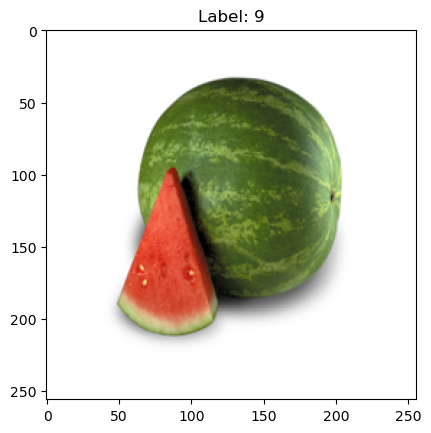

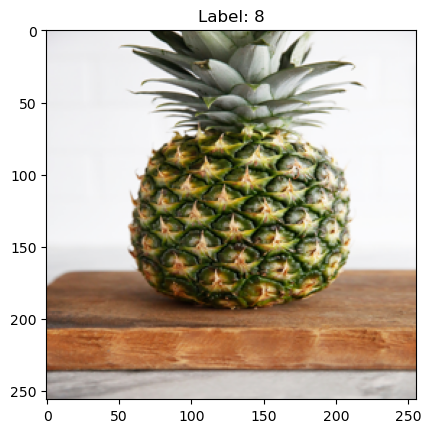

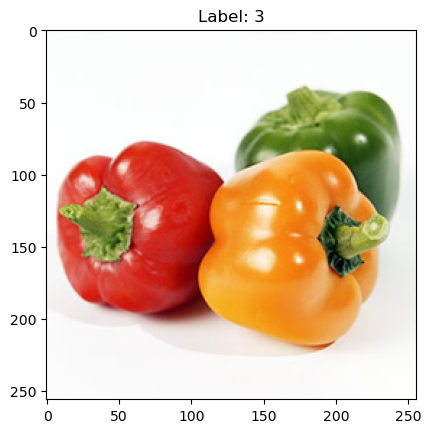

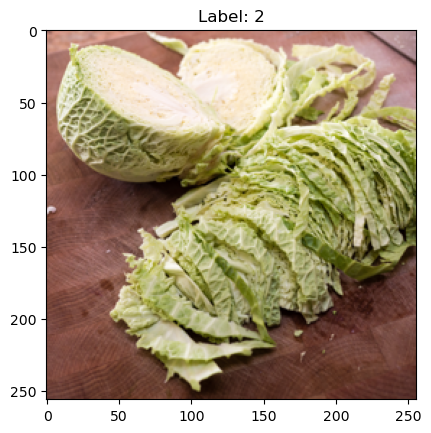

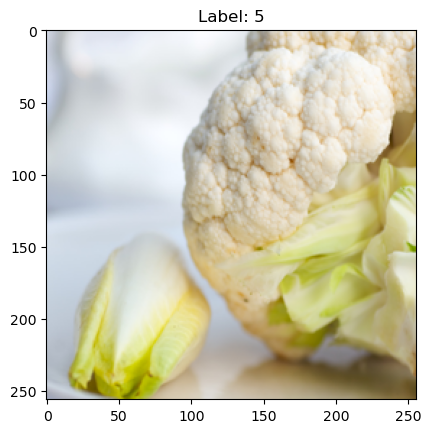

In [4]:
# Get a sample of images and labels
sample_size = 5  # Change this value to the number of samples you want
sample_df = df.sample(n=sample_size)

# Iterate through the sample DataFrame and display images with labels
for index, row in sample_df.iterrows():
    pixel_values = row[:-1].values  # Exclude the last column which contains labels
    label = row['labels']
    
    # Reshape the pixel values to the original image dimensions (256x256)
    image = pixel_values.reshape(256, 256, 3).astype(np.uint8)
    
    # Display the image with the corresponding label
    plt.figure()
    plt.imshow(image)
    plt.title(f"Label: {label}")
    plt.show()

In [5]:
df

0    1    2    3    4    5    6    7    8    9  ...  196599  196600  \
0    255  255  255  255  255  255  255  255  255  255  ...     255     255   
1    236  237  241  237  238  240  238  239  241  238  ...     252     254   
2    255  255  255  255  255  255  255  255  255  255  ...     255     255   
3    110  123   80  113  124   81  116  129   86  118  ...      74      89   
4    255  255  255  255  255  255  255  255  255  255  ...     255     255   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...     ...     ...   
920  124   98   91  126  100   93  128  102   94  129  ...     118     107   
921  255  255  255  255  255  255  255  255  255  255  ...     255     255   
922  208  130   91  195  112   77  191   98   65  187  ...     146     185   
923  255  255  255  255  255  255  255  255  255  255  ...     255     255   
924  245  247  246  245  247  246  245  247  246  245  ...     238     148   

     196601  196602  196603  196604  196605  196606  196607  labels  
0       255     255     255     255     255     255     255       0  
1       246     250     253     244     251     254     245       0  
2       255     255     255     255     255     255     255       0  
3        20      75      90      26      79      93      33       0  
4       255     255     255     255     255     255     255       0  
..      ...     ...     ...     ...     ...     ...     ...     ...  
920     106     107      96      96     124     109     106       9  
921     255     255     255     255     255     255     255       9  
922      58     154     193      47     147     188      38       9  
923     255     255     255     255     255     255     255       9  
924     147     239     152     150     240     154     156       9  

[925 rows x 196609 columns]

In [48]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split

In [49]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Initialize the encoder
label_encoder = LabelEncoder()

# Fit and transform the labels in the entire dataset
df['label'] = label_encoder.fit_transform(df['label'])

# Now split your dataset into features and labels again
X = df.drop(columns=['label'])
y = df['label']

# Normalize the features
X = X / 255.0

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [50]:
X

0         1         2         3         4         5         6  \
0    1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
1    0.945098  0.929412  0.925490  0.941176  0.933333  0.929412  0.945098   
2    1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
3    0.309804  0.482353  0.431373  0.313725  0.482353  0.447059  0.341176   
4    1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
..        ...       ...       ...       ...       ...       ...       ...   
847  0.058824  0.200000  0.133333  0.015686  0.156863  0.090196  0.050980   
848  0.721569  0.729412  0.772549  0.764706  0.768627  0.811765  0.760784   
849  0.803922  0.784314  0.772549  0.803922  0.784314  0.772549  0.803922   
850  0.117647  0.180392  0.349020  0.105882  0.168627  0.337255  0.101961   
851  0.047059  0.105882  0.129412  0.078431  0.149020  0.176471  0.086275   

            7         8         9  ...    196598    196599    196600  \
0    1.000000  1.000000  1.000000  ...  1.000000  1.000000  1.000000   
1    0.937255  0.933333  0.925490  ...  0.992157  0.964706  1.000000   
2    1.000000  1.000000  1.000000  ...  1.000000  1.000000  1.000000   
3    0.509804  0.458824  0.352941  ...  0.301961  0.086275  0.352941   
4    1.000000  1.000000  1.000000  ...  1.000000  1.000000  1.000000   
..        ...       ...       ...  ...       ...       ...       ...   
847  0.192157  0.125490  0.074510  ...  0.043137  0.031373  0.066667   
848  0.768627  0.811765  0.768627  ...  0.674510  0.776471  0.764706   
849  0.784314  0.772549  0.803922  ...  0.792157  0.843137  0.807843   
850  0.164706  0.333333  0.086275  ...  0.164706  0.054902  0.250980   
851  0.145098  0.172549  0.043137  ...  0.380392  0.070588  0.384314   

       196601    196602    196603    196604    196605    196606    196607  
0    1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  
1    0.988235  0.956863  0.992157  0.980392  0.960784  0.996078  0.984314  
2    1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  
3    0.294118  0.098039  0.341176  0.286275  0.137255  0.372549  0.317647  
4    1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  
..        ...       ...       ...       ...       ...       ...       ...  
847  0.058824  0.023529  0.058824  0.054902  0.003922  0.058824  0.035294  
848  0.733333  0.776471  0.764706  0.725490  0.772549  0.756863  0.737255  
849  0.792157  0.839216  0.803922  0.788235  0.835294  0.807843  0.792157  
850  0.180392  0.152941  0.364706  0.294118  0.105882  0.231373  0.172549  
851  0.184314  0.047059  0.329412  0.137255  0.070588  0.305882  0.184314  

[852 rows x 196608 columns]

In [51]:
y

0      0
1      0
2      0
3      0
4      0
      ..
847    9
848    9
849    9
850    9
851    9
Name: label, Length: 852, dtype: int32

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [52]:
num_classes=10

In [ ]:
import torch.optim as optim

# Define the loss function (Cross-Entropy)
criterion = nn.CrossEntropyLoss()

# Define the optimizer (e.g., Adam)
optimizer = optim.Adam(model.parameters(), lr=0.001)  # You can adjust the learning rate as needed


In [ ]:
from torch.utils.data import Dataset
from PIL import Image

In [29]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=5, verbose=True)

In [30]:
# Early stopping parameters
best_validation_loss = float('inf')
early_stopping_patience = 5
epochs_without_improvement = 0
num_epochs = 32  # Define the number of epochs

In [53]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

# Create custom datasets for training and validation
class CustomDataset(Dataset):
    def __init__(self, dataframe, label, transform=None):
        self.data = dataframe
        self.label = label
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Assuming each row in dataframe is flattened image data
        pixel_values = self.data.iloc[idx].values

        # Reshape and convert to uint8
        image = pixel_values.reshape(256,256, 3).astype(np.uint8)
        image = Image.fromarray(image)

        if self.transform:
            image = self.transform(image)

        # Get label
        label = self.label.iloc[idx]
        label = torch.tensor(label, dtype=torch.long)

        return {'image': image, 'label': label}

transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
])

In [80]:
# Create custom dataset instances
train_dataset = CustomDataset(dataframe=X_train, label=y_train, transform=transform)
val_dataset = CustomDataset(dataframe=X_val, label=y_val, transform=transform)

# Create data loaders
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [55]:
# Adjust learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)  # Try different values, e.g., 0.01, 0.0001

# Inspect a batch of data
sample_batch = next(iter(train_loader))
print("Sample inputs:", sample_batch['image'].shape)
print("Sample labels:", sample_batch['label'])

Sample inputs: torch.Size([16, 3, 256, 256])
Sample labels: tensor([0, 6, 2, 7, 3, 1, 6, 6, 5, 6, 2, 4, 2, 5, 3, 4])


In [41]:
import torch
import torch.nn as nn


class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc = nn.Linear(32 * 25 * 25, num_classes)  # Adjust input size for 100x100 images

    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Initialize the model
num_classes = 10  # Number of unique classes in the target
model = CustomCNN(num_classes)

# Display the model summary
print(model)

# Initialize the model
num_classes = 10  # Number of unique classes in the target
model = CustomCNN(num_classes)

# Display the model summary
print(model)


# Initialize the model
num_classes = 10  # Number of unique classes in the target
model = SimpleCNN(num_classes)

# Define loss function and optimizer

# Display the model summary
print(model)


CustomCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=20000, out_features=8, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=8, out_features=10, bias=True)
)
CustomCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=20000, out_features=8, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=8, out_features=10, bias=True)
)
SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool1): MaxPool2d(kernel_size=2

In [42]:
device = torch.device("cuda")  # Use the first available GPU
model.to(device)

SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=20000, out_features=10, bias=True)
)

In [43]:
num_epochs = 32
model.to(device)



# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)  # Adjust the learning rate

# Training loop
num_epochs = 32

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for i, batch in enumerate(train_loader):
        inputs = batch['image'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    # Print statistics
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')

print('Finished Training')

Epoch 1/32, Loss: 2.2906, Accuracy: 14.5611
Epoch 2/32, Loss: 2.2613, Accuracy: 16.3063
Epoch 3/32, Loss: 2.0226, Accuracy: 30.5809
Epoch 4/32, Loss: 1.4618, Accuracy: 52.6960
Epoch 5/32, Loss: 1.0841, Accuracy: 69.2107
Epoch 6/32, Loss: 0.8762, Accuracy: 76.1657
Epoch 7/32, Loss: 0.7247, Accuracy: 82.5736
Epoch 8/32, Loss: 0.6113, Accuracy: 85.6994
Epoch 9/32, Loss: 0.5165, Accuracy: 87.8354
Epoch 10/32, Loss: 0.4450, Accuracy: 90.1797
Epoch 11/32, Loss: 0.3840, Accuracy: 91.2477
Epoch 12/32, Loss: 0.3384, Accuracy: 92.2636
Epoch 13/32, Loss: 0.2983, Accuracy: 93.2274
Epoch 14/32, Loss: 0.2656, Accuracy: 93.9568
Epoch 15/32, Loss: 0.2423, Accuracy: 94.7382
Epoch 16/32, Loss: 0.2169, Accuracy: 95.1810
Epoch 17/32, Loss: 0.1982, Accuracy: 95.5197
Epoch 18/32, Loss: 0.1787, Accuracy: 96.1969
Epoch 19/32, Loss: 0.1621, Accuracy: 96.3793
Epoch 20/32, Loss: 0.1498, Accuracy: 96.8221
Epoch 21/32, Loss: 0.1331, Accuracy: 96.9784
Epoch 22/32, Loss: 0.1234, Accuracy: 97.6035
Epoch 23/32, Loss: 

In [5]:
import os
import shutil

# Source path of the training dataset
src_dir = r'C:\Users\MITUL\Documents\csv\vision\classification\fruits-360_dataset\fruits-360\Training'

# Destination path for the new folder
dest_dir = r'C:\Users\MITUL\Documents\csv\vision\classification\selected_data'

# List of selected fruits and vegetables
selected_classes = ['Apple Red Yellow 1', 'Kiwi', 'Grape Pink', 'Strawberry', 'Mango',
                    'Beetroot', 'Corn', 'Ginger Root', 'Cauliflower', 'Eggplant']

# Create the destination directory if it doesn't exist
os.makedirs(dest_dir, exist_ok=True)

# Copy selected images to the destination directory
for class_name in selected_classes:
    src_class_dir = os.path.join(src_dir, class_name)
    dest_class_dir = os.path.join(dest_dir, class_name)
    os.makedirs(dest_class_dir, exist_ok=True)
    for filename in os.listdir(src_class_dir):
        src_file = os.path.join(src_class_dir, filename)
        dest_file = os.path.join(dest_class_dir, filename)
        shutil.copy(src_file, dest_file)

print("Images copied to the destination folder.")


Images copied to the destination folder.


In [3]:
import os
import cv2
import pandas as pd

# Directory containing the images
image_dir = r'C:\Users\MITUL\Documents\csv\vision\classification\selected_data'

# List of selected fruit and vegetable classes
selected_classes = ['Apple Red Yellow 1', 'Kiwi', 'Grape Pink', 'Strawberry', 'Mango',
                    'Beetroot', 'Corn', 'Ginger Root', 'Cauliflower', 'Eggplant']

# Initialize lists to store pixel values and class labels
data = []
labels = []

# Loop through selected classes
for class_name in selected_classes:
    class_dir = os.path.join(image_dir, class_name)
    
    # Loop through images in each class
    for image_name in os.listdir(class_dir):
        image_path = os.path.join(class_dir, image_name)
        
        # Read the image
        img = cv2.imread(image_path)
        
        # Ensure the image is in RGB format
        if img.shape[-1] == 1:
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        
        # Flatten the image into a 1D array
        img_flat = img.flatten()
        
        # Append pixel values and class label to lists
        data.append(img_flat)
        labels.append(class_name)

# Create a Pandas DataFrame
df = pd.DataFrame(data)

# Add a column for class labels
df['label'] = labels

# Save the DataFrame to a CSV file
csv_file_path = r'C:\Users\MITUL\Documents\csv\vision\classification\selected_data.csv'
df.to_csv(csv_file_path, index=False)

print(f"CSV file saved to {csv_file_path}")


CSV file saved to C:\Users\MITUL\Documents\csv\vision\classification\selected_data.csv


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the CSV file containing image data and labels
csv_filename = "selected_data.csv"
df = pd.read_csv(csv_filename)



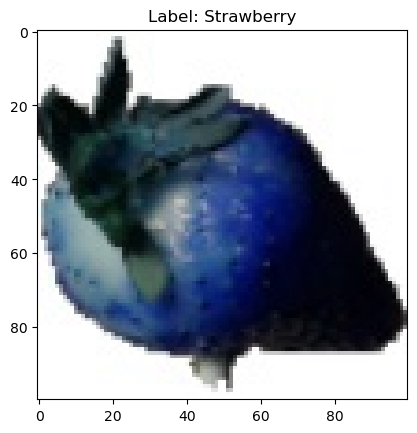

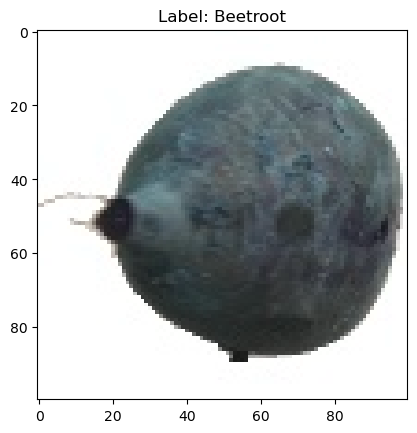

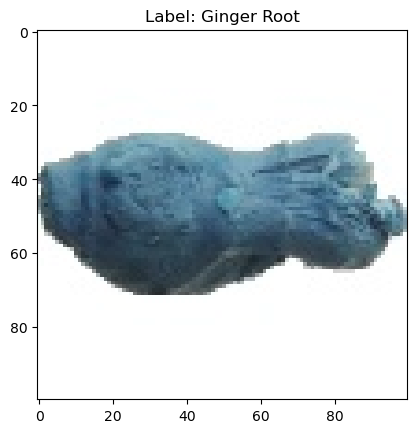

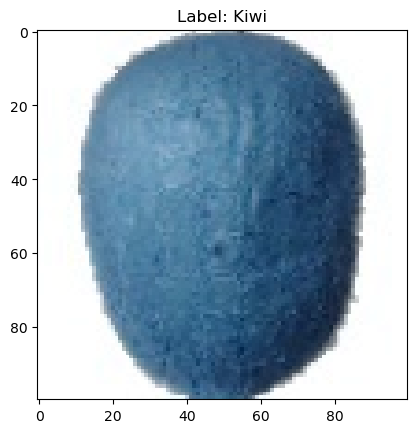

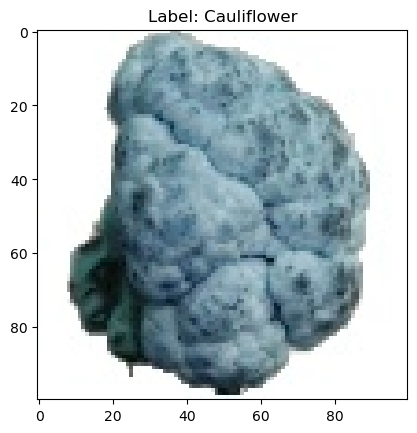

In [8]:
# Get a sample of images and labels
sample_size = 5  # Change this value to the number of samples you want
sample_df = df.sample(n=sample_size)

# Iterate through the sample DataFrame and display images with labels
for index, row in sample_df.iterrows():
    pixel_values = row[:-1].values  # Exclude the last column which contains labels
    label = row['label']
    
    # Reshape the pixel values to the original image dimensions (256x256)
    image = pixel_values.reshape(100, 100, 3).astype(np.uint8)
    
    # Display the image with the corresponding label
    plt.figure()
    plt.imshow(image)
    plt.title(f"Label: {label}")
    plt.show()

In [45]:
import os
import cv2
import pandas as pd
import numpy as np

# Directory containing the images
image_dir = r'C:\Users\MITUL\Documents\csv\vision\classification\train'

# List of selected classes (folders containing images)
selected_classes = ['apple' ,'banana' ,'cabbage' ,'capsicum' ,'carrot' ,'cauliflower' ,'eggplant' ,'grapes' ,'pineapple' ,'watermelon']

# Initialize lists to store pixel values and class labels
data = []
labels = []

# Image dimensions (3 for RGB, 256x256)
image_height = 256
image_width = 256
image_channels = 3

# Loop through selected classes
for class_name in selected_classes:
    class_dir = os.path.join(image_dir, class_name)
    
    # Loop through images in each class
    for image_name in os.listdir(class_dir):
        image_path = os.path.join(class_dir, image_name)
        
        # Read the image
        img = cv2.imread(image_path)
        
        # Resize the image to the desired dimensions (256x256)
        img = cv2.resize(img, (image_width, image_height))
        
        # Ensure the image is in RGB format
        if img.shape[-1] == 1:
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        
        # Flatten the image into a 1D array
        img_flat = img.flatten()
        
        # Append pixel values and class label to lists
        data.append(img_flat)
        labels.append(class_name)

# Create a Pandas DataFrame
df = pd.DataFrame(data)

# Add a column for class labels
df['label'] = labels

# Save the DataFrame to a CSV file
csv_file_path = r'C:\Users\MITUL\Documents\csv\vision\classification\try.csv'
df.to_csv(csv_file_path, index=False)

print(f"CSV file saved to {csv_file_path}")


CSV file saved to C:\Users\MITUL\Documents\csv\vision\classification\try.csv


In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the CSV file containing image data and labels
csv_filename = "try.csv"
df = pd.read_csv(csv_filename)

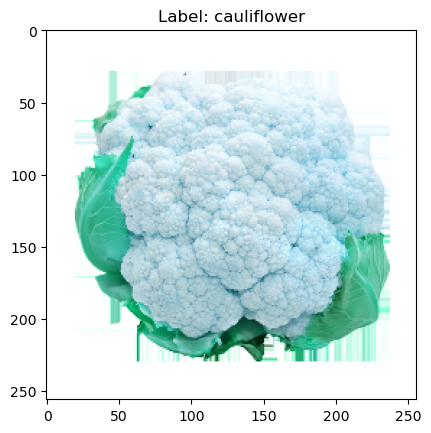

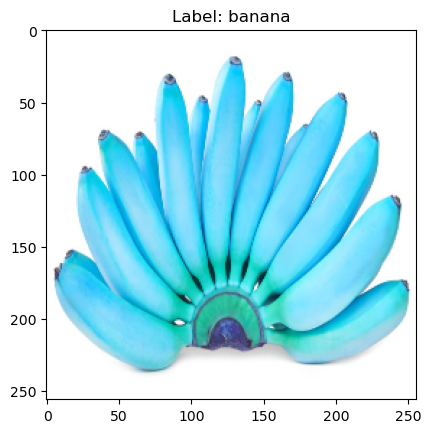

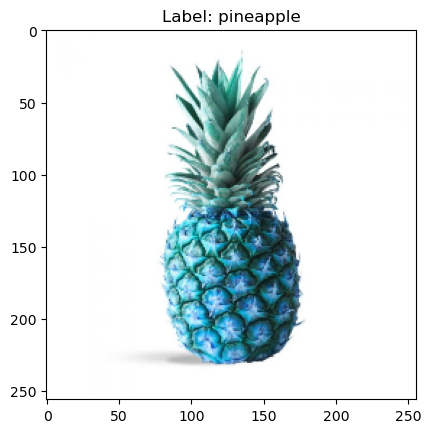

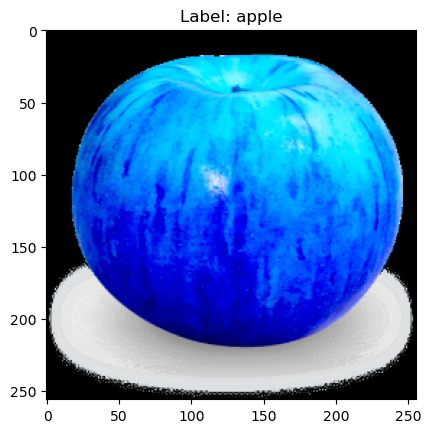

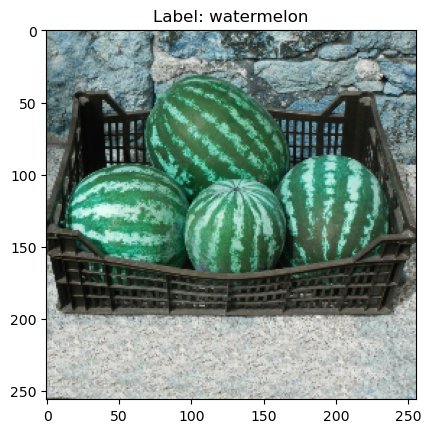

In [47]:
# Get a sample of images and labels
sample_size = 5  # Change this value to the number of samples you want
sample_df = df.sample(n=sample_size)

# Iterate through the sample DataFrame and display images with labels
for index, row in sample_df.iterrows():
    pixel_values = row[:-1].values  # Exclude the last column which contains labels
    label = row['label']
    
    # Reshape the pixel values to the original image dimensions (256x256)
    image = pixel_values.reshape(256,256, 3).astype(np.uint8)
    
    # Display the image with the corresponding label
    plt.figure()
    plt.imshow(image)
    plt.title(f"Label: {label}")
    plt.show()

In [115]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FruitVegCNN(nn.Module):
    def __init__(self, num_classes):
        super(FruitVegCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(128 * 32 * 32, 1024)
        self.fc2 = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 128 * 32 * 32)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


# Example of initializing the model with a specific number of classes
num_classes = 10  # Adjust this to match the number of fruit/vegetable classes in your dataset
model = FruitVegCNN(num_classes)


In [116]:
device = torch.device("cuda")  # Use the first available GPU
model.to(device)

FruitVegCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=131072, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=10, bias=True)
)

In [117]:
num_epochs = 32
model.to(device)



# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)  # Adjust the learning rate

# Training loop
num_epochs = 32

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for i, batch in enumerate(train_loader):
        inputs = batch['image'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    # Print statistics
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')

print('Finished Training')

Epoch 1/32, Loss: 3.3294, Accuracy: 15.5653
Epoch 2/32, Loss: 1.7691, Accuracy: 39.6476
Epoch 3/32, Loss: 1.3012, Accuracy: 55.9471
Epoch 4/32, Loss: 0.9408, Accuracy: 71.3656
Epoch 5/32, Loss: 0.7425, Accuracy: 78.1204
Epoch 6/32, Loss: 0.7200, Accuracy: 76.5051
Epoch 7/32, Loss: 0.5076, Accuracy: 85.3157
Epoch 8/32, Loss: 0.4571, Accuracy: 86.6373
Epoch 9/32, Loss: 0.4232, Accuracy: 87.8120
Epoch 10/32, Loss: 0.3762, Accuracy: 89.7210
Epoch 11/32, Loss: 0.6328, Accuracy: 88.9868
Epoch 12/32, Loss: 0.5836, Accuracy: 86.4905
Epoch 13/32, Loss: 0.5137, Accuracy: 85.0220
Epoch 14/32, Loss: 0.3662, Accuracy: 89.7210
Epoch 15/32, Loss: 0.3667, Accuracy: 89.4273
Epoch 16/32, Loss: 0.7215, Accuracy: 83.7004
Epoch 17/32, Loss: 0.2849, Accuracy: 91.4831
Epoch 18/32, Loss: 0.2532, Accuracy: 92.0705
Epoch 19/32, Loss: 0.2431, Accuracy: 92.8047
Epoch 20/32, Loss: 0.3354, Accuracy: 91.0426
Epoch 21/32, Loss: 0.4083, Accuracy: 88.3994
Epoch 22/32, Loss: 0.3462, Accuracy: 90.6021
Epoch 23/32, Loss: 